In [1]:
from environment import utils, Environment
from importlib import reload
import matplotlib.pyplot as plt


from absl import flags
FLAGS = flags.FLAGS

import numpy as np

if not FLAGS.find_module_defining_flag('vega_obs', default=None): 
    flags.DEFINE_boolean('vega_obs', True, 'Include portfolio vega and hedging option vega in state variables (Default False)')
# set vega obs to True to include vega in state variables
FLAGS['vega_obs'].value = True
FLAGS.mark_as_parsed()



In [2]:
np.set_printoptions(precision=10, suppress=True)
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

In [3]:
reload(utils)
reload(Environment)
util = utils.Utils()

env = Environment.TradingEnv(utils=util)
%load_ext autoreload
%autoreload 2

env.reset()

utils initiated with spread=0, poisson_rate=1, n_episodes=1000

Memory usage before lmm: 335.79 MB
t_max set to 7
!!!! CONTRACT SIZE IS  100.0
Memory usage after: 336.90 MB

Memory usage after gc: 336.90 MB

initializing classes
done initializing classes
Main portfolio initialized with kernel beta of  1.0  using triangle kernel
REMEMBER TO ADD BACK THE SENSITIVITY FOR LIAB AND HEDGE WHEN USING THE RBF KERNEL


/home/hedge/venv/lib/python3.9/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


array([34513.09375     ,     0.0243248511,   387.0051574707,   380.5766601562,     0.          ,     1.590865612 ,     1.9754823446,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,     0.          ,    

In [4]:

print(env.t)
env.step([0,1])[2]
env.portfolio.get_gamma(env.t)
env.portfolio.get_gamma_local_hed(env.t)
env.portfolio.get_vega

0


ValueError: not enough values to unpack (expected 7, got 2)

In [7]:
tau_vals = np.arange(0, 2 + 1e-3, 1/52).astype(np.float32)
tau_vals.shape

(105,)

In [ ]:
env.portfolio.get_delta_vec(env.t).shape[0]-env.portfolio.get_delta_vec(env.t).shape[0]/2

52.0

In [ ]:
from functools import partial
def get_instant_vol_func(tau_i , a,b,c,d):

    tau = np.maximum(tau_i, 0)
    instantaneous_vol = (a + b * tau) * np.exp(-c * tau) + d
    return instantaneous_vol

def doust_corr(tau_i,tau_j, eta, beta):
    return eta + (1-eta) * np.exp(-beta*np.abs(tau_i-tau_j))

def trainable_kernel(tau_i, tau_j, a, b, c, d, eta, beta):
    return doust_corr(eta, beta, tau_i,tau_j) * get_instant_vol_func(tau_j , a,b,c,d) / get_instant_vol_func(tau_i , a,b,c,d)
    


low_bounds = {'a': 1, 'b': 1, 'c': 1, 'd': 0.001}

ts = np.linspace(0,3,105+52) # 3 yers
print(ts.shape)
vols = get_instant_vol_func(ts,low_bounds.values())
delta_kernel =  vols[:,None]/vols[52] # normalized to 1y mark
 
plt.plot(ts,delta_kernel)
plt.show()

(157,)


TypeError: get_instant_vol_func() missing 3 required positional arguments: 'b', 'c', and 'd'

In [ ]:
ts = np.arange(0,3,1/52) # 3 yers
ts[104]

2.0

In [ ]:
import numpy as np
import sonnet as snt
import tensorflow as tf
import tensorflow_probability as tfp

# Alias for bijectors
tfb = tfp.bijectors

class OneYearKernelLayer(snt.Module):
    """
    Sonnet module acting like a layer: takes a risk vector [T] and returns
    a single exposure scalar. Internally computes trainable kernel weights
    anchored at a fixed tenor (1y at index anchor_index).

    Usage:
        exposure = kernel_layer(risk_vector)

    Parameters a,b,c,d,eta,beta are constrained to (0,1) via Sigmoid bijector.
    """
    def __init__(self,
                 tenor_grid=None,
                 anchor_index=52,
                 init_params=None,
                 a_scale = 0.2,
                 b_scale=0.2,
                 c_scale = 1.5,
                 d_scale=0.5,

                 name=None):
        super().__init__(name=name)
        # Build tenor grid: default 0 to 3 years at 1/52
        if tenor_grid is None:
            tau_vals = np.arange(0, 2+1e-5, 1/52).astype(np.float32)
        else:
            tau_vals = np.array(tenor_grid, dtype=np.float32)
        self.tau_grid = tf.constant(tau_vals, dtype=tf.float32)
        self.anchor_index = anchor_index

        # Initial params in (0,1)
        defaults = init_params or {'a':0.5,'b':0.5,'c':1.,'d':0.001,'eta':0.5,'beta':0.5}
        sigmoid = tfb.Sigmoid()
        # Vol function params
        self.a    = tfp.util.TransformedVariable(defaults['a'],    sigmoid, name='a') * a_scale
        self.b    = tfp.util.TransformedVariable(defaults['b'],    sigmoid, name='b') * b_scale
        self.c    = tfp.util.TransformedVariable(defaults['c'],    sigmoid, name='c') * c_scale
        self.d    = tfp.util.TransformedVariable(defaults['d'],    sigmoid, name='d')*d_scale + 0.001
        # Correlation params
        self.eta  = tfp.util.TransformedVariable(defaults['eta'],  sigmoid, name='eta')*0.95
        self.beta = tfp.util.TransformedVariable(defaults['beta'], sigmoid, name='beta')*0.5

    def _compute_weights(self):
        """
        Compute the kernel weight vector [T]."""
        tau = self.tau_grid                             # [T]
        vols = (self.a + self.b * tau)*tf.exp(-self.c * tau) + self.d  # [T]
        vol_ref = vols[self.anchor_index]                # scalar
        tau_ref = tau[self.anchor_index]                 # scalar
        dist = tf.abs(tau - tau_ref)                     # [T]
        corr = self.eta + (1. - self.eta)*tf.exp(-self.beta * dist)  # [T]
        return corr * (vols / vol_ref)                   # [T]

    def __call__(self, risk_vector):
        """
        Args:
          risk_vector: 1D tensor [T] of risk sensitivities.
        Returns:
          scalar exposure.
        """
        weights = self._compute_weights()                # [T]
        plt.clf()
        plt.plot(weights)
        plt.show()
        return tf.reduce_sum(weights * risk_vector)      # scalar

In [ ]:
layer = OneYearKernelLayer()

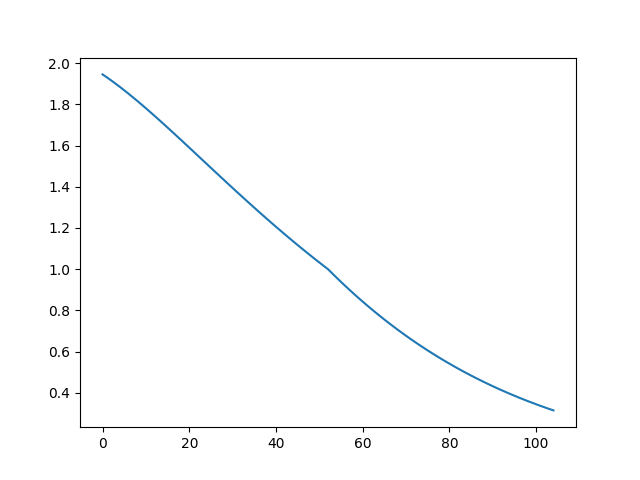

<tf.Tensor: shape=(), dtype=float32, numpy=108.80518>

In [ ]:
layer(np.ones(105))

In [ ]:
t=52
gv = np.arange(1,3+1e-3,1/52)[:53+t]
gt = np.zeros(105)
gt[52-t:] = gv

print(gt[:,None][52])

[2.]
